# Algorithm implementation: Multi-focus image fusion using learning based matting with sum of the Gaussian-based modified Laplacian

<style>
ol {
  counter-reset: item
}
li {
  display: block
}
li:before {
  content: counters(item, ".") " ";
  counter-increment: item
}
</style>
<h2>Table of Contents </h2>

<ol>
    <li><a href="#workspace-setup">Workspace setup</a></li>
    <li><a href="#data-loading">Load and process images</a></li>
    <li><a href="#algorithm-implementation">Algorithm implementation</a>
        <ol>
            <li><a href="#31-sgml-sum-of-the-modified-laplacian">Sum of the modified laplacian</a></li>
            <li><a href="#32-strategy-of-initial-segmentation">Strategy of initial segmentation</a></li>
            <li><a href="#33-image-matting-technique-for-fusion">Image matting technique for fusion</a></li>
        </ol>
    </li>
    <li><a href="#references">References</a></li>
</ol>


<a id="workspace-setup"></a>
# 1. Workspace Setup

## Downloading MFIF dataset

- To facilitate easy access to the required dataset for the image processing algorithm, we provide a shell script that automates the download and setup process
- In order for data to be downloaded uncomment and run the cell below

In [38]:
# !./load_data.sh

## Enviroment Setup

- Following best practices create a virtual environment to isolate project dependencies using your preferred maganer. If you are using `venv` run the following commands:
    1. Create virtual environment in the current workspace:
    ```bash
      python3 -m venv .venv/mfif
    ``` 
  2. Activate the virtual environment:
    ```bash
    .venv\mfif\Scripts\activate       # Windows
    source .venv/mfif/bin/activate    # Unix or MacOS
  ```
  3. Once the virtual environment is activated, install the required packages:
    ```bash
    pip install -r requirements.txt
    ```

<a id="data-loading"></a>
# 2. Load and process images

* Import the neccesary libraries to run this project
* Define a **path variable** that points towards the data directory that is created through the **.sh** script. 
* Create a class that handless the proces of retrieving paths to images from the data directory
* Use the paths to load and process images using <code>cv2</code>

In [39]:
from pathlib import Path
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import const


In [40]:
class DataFolder:
    """
    A wrapper for the folder containing images for the multi-focus fusion task.

    This class provides a convenient way to access and manage a folder containing images for the multi-focus fusion task. 
    The folder is expected to contain a set of subfolders, each of which contains two images with opposite focus.

    Attributes:
        path (Path): A pathlib.Path object representing the path to the folder containing the images.

    Methods:
        get_images(folder_name: str = None) -> np.ndarray[Path]:
            Returns the images from the specified folder_name. If no name is provided, a random pair of images from the data folder are selected.
    """

    def __init__(self, path: Path):
        self.path = path
        self._folder = None

    def get_images(self, folder_name: str = None) -> np.ndarray[Path]:
        """
        Get the images from the specified folder_name.

        This method takes as input a folder name and returns a numpy array of pathlib.Path objects 
        representing the paths to the images in the specified folder. If no folder name is provided, 
        a random pair of images from the data folder are selected.

        Args:
            folder_name (str, optional): A string representing the name of the folder from which to get the images. 
                                        If None, a random pair of images from the data folder are selected. Defaults to None.

        Returns:
            np.ndarray[Path]: A numpy array of pathlib.Path objects representing the paths to the images.
        """
        if folder_name is None:
            self._folder = self.path / np.random.choice(os.listdir(self.path))
        else:
            self._folder = self.path / folder_name

        img_paths = []
        for img in sorted(Path(self._folder.as_posix()).glob("*.jpg")):
            img_paths.append(img)

        return np.array(img_paths)
    
    @property
    def folder(self):
        return os.path.basename(self._folder)

In [41]:
def process_images(img_paths: np.ndarray[Path]) -> np.ndarray:
    """
    Processes a list of images: converts them to RGB color channels.

    This function takes as input a list of image paths, reads each image, converts it from BGR to RGB color space, 
    and appends it to a list. The list of images is then converted to a numpy array and returned.

    Args:
        img_paths (np.ndarray[Path]): A numpy array of pathlib.Path objects representing the paths to the images.

    Returns:
        np.ndarray: A 3D numpy array where the first dimension represents the image index and the second and third
        dimensions represent the y and x coordinates of a pixel. Each element represents the RGB color of the pixel.
    """
    imgs = []
    for img_path in img_paths:
        img = cv.imread(img_path.as_posix())
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgs.append(img)

    return np.array(imgs)

In [42]:
def plot_images(
    images: np.ndarray,
    titles: list[str] = ["Img1", "Img2"],
    isGrayscale: bool = False,
    saveImage: bool = False,
    savePath: Path = None,
):
    """
    Plots a list of images with optional titles, and saves the plot to a file if desired.

    Args:
        images (np.ndarray): A list of images to be plotted. Each image should be a numpy array.
        titles (list[str], optional): A list of titles for the images. Defaults to ["Img1", "Img2"].
        isGrayscale (bool, optional): If True, the images are displayed in grayscale. Defaults to False.
        saveImage (bool, optional): If True, the plot is saved to a file. Defaults to False.
        savePath (Path, optional): The path where the plot should be saved. Required if saveImage is True.

    Raises:
        AssertionError: If saveImage is True but savePath is None or an empty string.

    Returns:
        None
    """
    num_images = len(images)
    if num_images == 1:
        # Only 1 image was passed in
        plt.figure()
        if isGrayscale:
            plt.imshow(images[0], cmap="gray")
        else:
            plt.imshow(images[0])
        plt.title(titles[0])
        plt.axis("off")
    else:
        # Multiple images were passed in
        num_rows = int(np.ceil(num_images / 2))
        fig, axes = plt.subplots(num_rows, 2, figsize=(15, 15 * num_rows))
        axes = axes.ravel()  # Flatten the axes array
        for i, ax in enumerate(axes):
            if i < num_images:  # Only plot if there is an image for this subplot
                if images[i].ndim == 2:
                    ax.imshow(images[i], cmap="gray")
                else:
                    ax.imshow(images[i])
                if titles:
                    ax.set_title(titles[i])
            ax.axis("off")
            ax.set_yticks([])
    if saveImage:
        assert (
            savePath is not None and savePath != ""
        ), "Invalid save path. Image not saved."
        plt.savefig(savePath, bbox_inches="tight")
    plt.show()

The **MFIF** process starts with two images of the same scene which are captured with different focus settings, for example one might have a focused foreground while the background is blurry and vice versa.

The final goal is to produce a composite image using the best part of each input in order to obtain a scene that is well-focused, overcoming the limitations of the camera focus depth.

Data directory located at: 
	/home/astanea/code/image_processing/Image-Processing/data
Selecting images from the following paths:
	/home/astanea/code/image_processing/Image-Processing/data/mffw_02/mffw_02_A.jpg
	/home/astanea/code/image_processing/Image-Processing/data/mffw_02/mffw_02_B.jpg
Processed images with shape: (2, 368, 592, 3)
	Num images: 2
	Height: 368
	Width: 592
	Num channels: 3


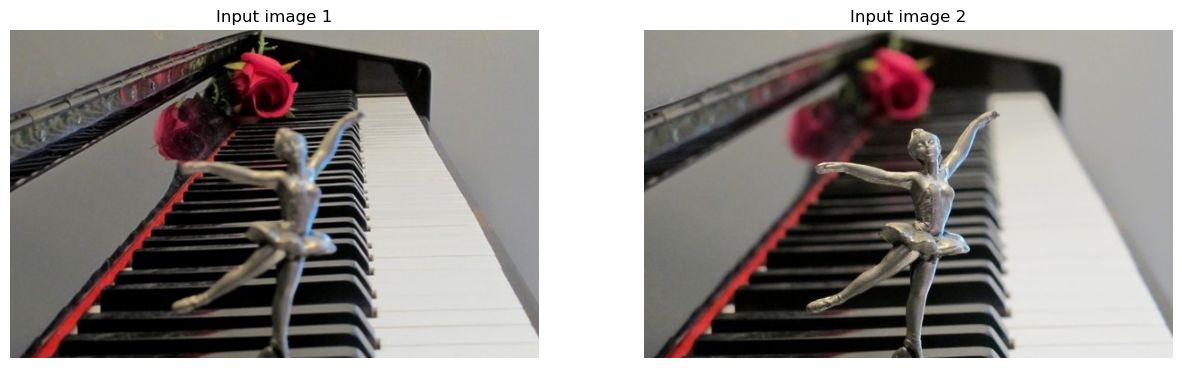

In [43]:
DATA_DIR = Path.cwd() / "data"
print(f"Data directory located at: \n\t{DATA_DIR.as_posix()}")

data_folder = DataFolder(DATA_DIR)
images = data_folder.get_images() # give a folder name to select a specific pair of images

results_path = Path("figures")
save_fig_folder = results_path / data_folder.folder
save_fig_folder.mkdir(parents=True, exist_ok=True)

print("Selecting images from the following paths:")
for img in images:
    print(f"\t{img}")

images = process_images(images)
print(f"Processed images with shape: {images.shape}")
for descriptor, value in zip(
    ["Num images", "Height", "Width", "Num channels"], images.shape
):
    print(f"\t{descriptor}: {value}")

plot_images(
    images,
    titles=["Input image 1", "Input image 2"],
    saveImage=True,
    savePath=save_fig_folder / "01_input_images.png",
)

<a id="algorithm-implementation"></a>
# 3. Algorithm implementation

<a id="#31-sgml-sum-of-the-modified-laplacian"></a>
## 3.1. SGML: Sum of the modified Laplacian

-  The proposed method: SGML is used to solve the task of image fusion wich consist in the combination of multiple images with different focus depths into a single all-in-focus image.
-  **SGML** is an advanced focus measure, whihch enhances the capabilities of previous SML implementation. The primary advantage is represented by its superior ability to distinghuis focus regions from defocused ones, especially in areas with low contrast.

In [44]:
def plot_kernel_1D(kernel):
    """
    Plots a representation of a 1D kernel.

    This function takes a 1D kernel as input and creates a plot using matplotlib. The x-axis represents the indices of the kernel, and the y-axis represents the value of the kernel at that index.

    Args:
        kernel (np.ndarray): A 1D numpy array representing the kernel to be plotted.

    Returns:
        None
    """
    plt.figure()
    plt.plot(kernel)
    plt.title("Representation of 1D Gaussian Kernel")
    plt.xlabel("Index")
    plt.ylabel("Kernel Value")
    plt.show()

In [45]:
def plot_kernel_2D(kernel):
    """
    Plots a 3D representation of a 2D kernel.

    This function takes a 2D kernel as input and creates a 3D plot using matplotlib. The x and y coordinates represent the indices of the kernel, and the z coordinate represents the value of the kernel at that index.

    Args:
        kernel (np.ndarray): A 2D numpy array representing the kernel to be plotted.

    Returns:
        None
    """
    # Create the x and y coordinate arrays
    x = np.arange(kernel.shape[0])
    y = np.arange(kernel.shape[1])
    x, y = np.meshgrid(x, y)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, kernel, cmap="viridis")

    # Labels and title
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Kernel Value")
    ax.set_title("3D Representation of 2D Gaussian Kernel")

    # Show the plot
    plt.show()

- The Gaussian kernel provides a weighted average where pixels closer to the central pixel have higher weights than those further away. This weighted averaging is more effective in preserving important image features while reducing noise, as opposed to a simple average where every pixel has equal weight
- The Gaussian kernel tends to preserve edges better than other types of blurring. This property makes is useful in applications such as edge detection and image segmentation.
- Having a gaussian distribution, the sum of the weights always add up to 1.

In [46]:
gaussian_kernel_1D = cv.getGaussianKernel(const.KERNEL_SIZE, const.SIGMA)
gaussian_kernel_2D = np.outer(gaussian_kernel_1D, gaussian_kernel_1D.transpose())

print(f"gaussian_kernel_1D shape: {gaussian_kernel_1D.shape}")
print(np.sum(gaussian_kernel_1D))
print(gaussian_kernel_1D)
print(f"gaussian_kernel_2D shape: {gaussian_kernel_2D.shape}")
print(np.sum(gaussian_kernel_2D))
print(gaussian_kernel_2D)

gaussian_kernel_1D shape: (7, 1)
0.9999999999999999
[[0.07015933]
 [0.13107488]
 [0.19071282]
 [0.21610594]
 [0.19071282]
 [0.13107488]
 [0.07015933]]
gaussian_kernel_2D shape: (7, 7)
0.9999999999999999
[[0.00492233 0.00919613 0.01338028 0.01516185 0.01338028 0.00919613
  0.00492233]
 [0.00919613 0.01718062 0.02499766 0.02832606 0.02499766 0.01718062
  0.00919613]
 [0.01338028 0.02499766 0.03637138 0.04121417 0.03637138 0.02499766
  0.01338028]
 [0.01516185 0.02832606 0.04121417 0.04670178 0.04121417 0.02832606
  0.01516185]
 [0.01338028 0.02499766 0.03637138 0.04121417 0.03637138 0.02499766
  0.01338028]
 [0.00919613 0.01718062 0.02499766 0.02832606 0.02499766 0.01718062
  0.00919613]
 [0.00492233 0.00919613 0.01338028 0.01516185 0.01338028 0.00919613
  0.00492233]]


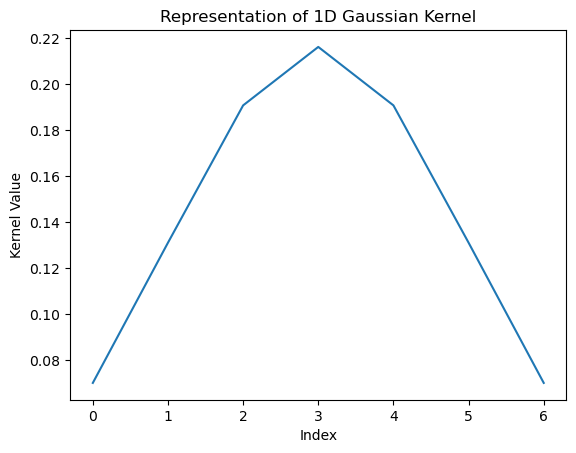

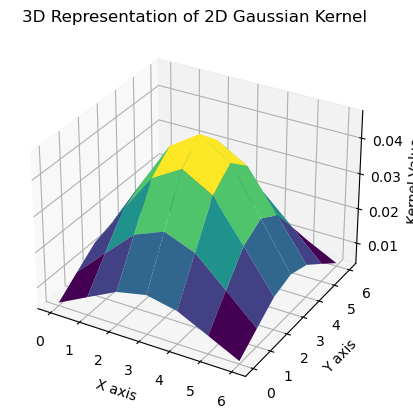

In [47]:
plot_kernel_1D(gaussian_kernel_1D)
plot_kernel_2D(gaussian_kernel_2D)

### Utility methods

- **Padding:**

    When applying the convolution operation, the edges of the original image get shrunk. In order to preserve the original size, we add zeros around the borders to compensate for the size loss.

- **Convolution Operation:**

    Given an image of size $W \times H$ ($W$ - width and $H$ - height) and a square kernel of size $k \times k$ ($k$ is typically an odd number in order to have a centered kernel), the size of the output image after applying the kernel will be: $$(W - k + 1) \times (H - k + 1)$$

NOTE: 
* The custom convolution allows us to manipulate the operation at every step by giving aces to the X and Y coordinates, as well as the current patch of the original image. Custom logic can be then applied if we want to use only certain pixels. In case we want to do a normal convolution, then we would do a dot product with the desired kernel.
* Also notice that we only implement the convolution operation on the valid pixel locations from the original image. In order to be correct mathematically the border should be cropped. 

In [48]:
def pad_images(images: np.ndarray, padding: int, border=cv.BORDER_CONSTANT):
    """
    Takes a list of images and pads them with zeros or other specified border types.

    Args:
        images (np.ndarray): List containing images to be padded as numpy arrays.
        padding (int): Padding to be applied to each image. This is the number of pixels to be added to each individual side of the image.
        border (int, optional): Pixel extrapolation method. Defaults to `cv.BORDER_CONSTANT` which pads the image with a constant value.

    Returns:
        np.ndarray: Padded images as a numpy array.
    """
    padded_images = []

    for idx, img in enumerate(images):
        replicate = cv.copyMakeBorder(
            img, padding, padding, padding, padding, border, value=0
        )
        padded_images.append(replicate)

    return np.array(padded_images)

In [49]:
def convolution_iterator(img: np.ndarray, kernel: np.ndarray, verbose=False):
    """
    Iterates over an image applying a convolution window.

    This function iterates over each pixel in the input image, skipping the outer edges, and yields a window of the image centered on the current pixel. The size of the window is determined by the size of the kernel.

    Args:
        img (np.ndarray): The input image, a 2D numpy array.
        kernel (np.ndarray): The kernel to be used in the convolution, a 2D numpy array.
        verbose (bool, optional): If True, prints additional information about the computation. Defaults to False.

    Yields:
        tuple: A tuple containing the row and column of the current pixel and the window of the image centered on this pixel.
    """
    height_img, width_img = img.shape
    height_kernel, width_kernel = kernel.shape

    if verbose:
        print(f"\t\tkernel_shape: {kernel.shape}")
        print(f"\t\timg shape: {img.shape}")
        print(f"\t\ty_start (IDX) = {(height_kernel // 2) -1}")
        print(f"\t\ty_end (IDX) = {(height_img - height_kernel // 2) -1}")
        print(f"\t\tx_start (IDX) = {(width_kernel // 2 -1) -1}")
        print(f"\t\tx_end (IDX) = {(width_img - width_kernel // 2) -1}")
        print(f"\t\twindow shape: {(height_kernel, width_kernel)}")

    # Loop through each pixel in the image skipping the outer edges of the image
    for row in range(height_kernel // 2, height_img - height_kernel // 2):
        for col in range(width_kernel // 2, width_img - width_kernel // 2):
            window = img[
                row - height_kernel // 2 : row + height_kernel // 2 + 1,
                col - width_kernel // 2 : col + width_kernel // 2 + 1,
            ]
            yield (row, col, window)

###  Sum of the modified Laplacian (ML)

The **Modified Laplacian (ML)** is a second-order derivative operator commonly used in image processing to extract edge information. The ML is particularly effective in highlighting areas with high gradient values, which are indicative of edges or transitions in an image. However, the ML has a limitation in that the second derivatives in the x and y directions might have opposite signs, leading to their cancellation and potentially missing some edge information.

To address this, the Modified Laplacian is defined as follows:


$$
ML(x, y) = \left| 2f(x, y) - f(x - s, y) - f(x + s, y) \right| + \left| 2f(x, y) - f(x, y - s) - f(x, y + s) \right|
$$

Here,  $f(x, y)$  represents the pixel intensity at position (x, y), and $s$ is a variable step size.

The Sum of the Modified Laplacian (SML) at a point (x, y) is then calculated by summing the values of the Modified Laplacian within a specified window around that point, but only for those ML values that exceed a certain threshold. This process is mathematically represented as:

$$
SML(x, y) = \sum_{i=x-r}^{x+r} \sum_{j=y-r}^{y+r} ML(i, j) \quad \text{for} \quad ML(i, j) > T
$$

In this equation, $T$ denotes the threshold value (often set to 0), and $r$ determines the window size for calculating the focus measure.

In [50]:
def ML(images, kernel_size, step_size=1, verbose=False):
    """
    Applies a Modified Laplacian (ML) operator to a set of images.

    The function iterates over the given images and applies the ML operator to each one. The ML operator is a high-pass filter that is used to detect edges in an image. It calculates the second derivative of the image intensity at each pixel and combines them into a single value using an absolute difference operation.

    Args:
        images (list of np.ndarray): A list of 2D numpy arrays representing grayscale images.
        kernel_size (int): The size of the kernel to be used in the convolution operation.
        step_size (int, optional): The number of pixels the sliding window moves after each computation. Defaults to 1.
        verbose (bool, optional): If True, prints additional information about the computation. Defaults to False.

    Returns:
        np.ndarray: A 3D numpy array where the first dimension represents the image index and the second and third 
                    dimensions represent the y and x coordinates of a pixel. Each element represents the pixel value of the filtered image.
    """
    kernel = np.ones((kernel_size, kernel_size))

    if verbose:
        print(f"\tkernel shape: {kernel.shape}")
        print(f"\tstep_size: {step_size}")

    ml_images = []
    for img in images:
        crnt_ml = np.zeros_like(img)
        for row, col, _ in convolution_iterator(img, kernel, verbose):
            crnt_ml[row, col] = np.abs(
                2 * img[row, col]
                - img[row - step_size, col]
                - img[row + step_size, col]
            )
            +np.abs(
                2 * img[row, col]
                - img[row, col - step_size]
                - img[row, col + step_size]
            )
        ml_images.append(crnt_ml)
    return np.array(ml_images)

###  Sum of the Gaussian-based modified Laplacian
The **Sum of the Gaussian-Based Modified Laplacian (SGML)** enhances the robustness of the Modified Laplacian (ML) by incorporating a Gaussian weighting. This approach begins with the calculation of the Modified Laplacian gradients for the source images, followed by a convolution with a Gaussian kernel. The process is mathematically expressed as follows:

1. **Modified Laplacian (ML)**:
   The ML is calculated using the formula:

   $$
   ML(x, y) = \left| 2f(x, y) - f(x - s, y) - f(x + s, y) \right| + \left| 2f(x, y) - f(x, y - s) - f(x, y + s) \right|
   $$

   where $f(x, y)$ is the pixel intensity at position $(x, y)$, and $s$ is a variable step size.

2. **Gaussian-Based Modified Laplacian (GML)**:
   The GML is obtained by convolving the ML with a Gaussian kernel:

   $$
   GML(x, y) = ML(x, y) * G_{\sigma}(x, y)
   $$

   where $G_{\sigma}(x, y)$ is the Gaussian kernel with standard deviation $\sigma$, and $*$ denotes the convolution operator.

3. **Sum of the Gaussian-Based Modified Laplacian (SGML)**:
   The SGML is then defined as the sum of GML values within a specified window around each point $(x, y)$:

   $$
   SGML(x, y) = \sum_{i=x-r}^{x+r} \sum_{j=y-r}^{y+r} GML(i, j)
   $$

   Here, $r$ determines the window size for the calculation.


In [ ]:
def SGML(ml_images, kernel, verbose=False):
    """
    Applies a Spatial Gaussian Maximum Likelihood (SGML) filter to a set of images.

    The function iterates over the given images and applies a 2D Gaussian kernel to each one using a convolution operation.
    The result of the convolution is a new image where each pixel value is the sum of the product of the kernel and a window of the original image centered on that pixel.
    The window size is determined by the size of the kernel.

    Args:
        ml_images (list of np.ndarray): A list of 2D numpy arrays representing grayscale images.
        kernel (np.ndarray): A 2D numpy array representing the Gaussian kernel to be applied to each image.
        verbose (bool, optional): If True, prints additional information about the computation. Defaults to False.

    Returns:
        np.ndarray: A 3D numpy array where the first dimension represents the image index and the second and third 
                    dimensions represent the y and x coordinates of a pixel. Each element represents the pixel value of the filtered image.
    """
    if verbose:
        print(f"\tgaussian_kernel_2D shape: {kernel.shape}")
        print(f"Gaussina kernel: {kernel}")

    sgml_images = []
    for img in ml_images:
        crnt_img = np.zeros_like(img)
        for row, col, window in convolution_iterator(img, gaussian_kernel_2D):
            crnt_img[row, col] = np.sum(window * gaussian_kernel_2D)
        sgml_images.append(crnt_img[3:-3, 3:-3])

    return np.array(sgml_images)

The steps required for the task of focus measurement are the following:

The first step is to convert the RGB image to grayscale format in order to reduce computation complexity since focus information is consistent and the operation would be redundant if performed across every channel.

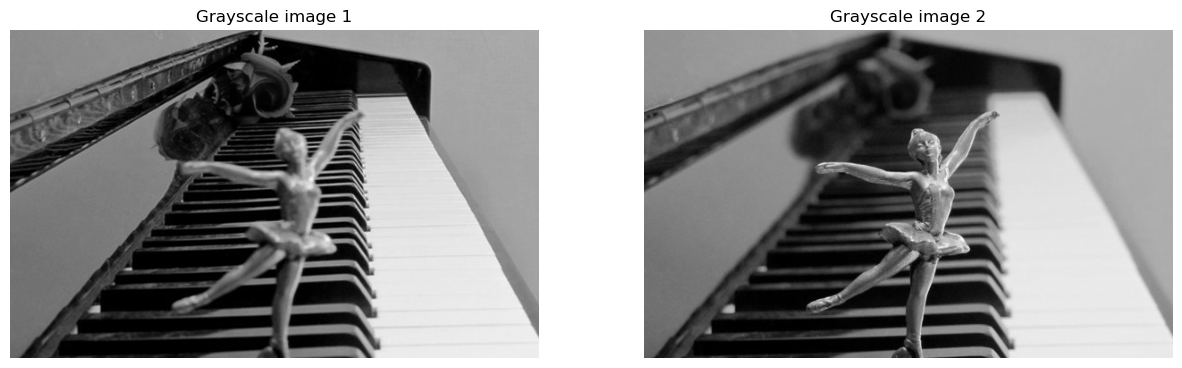

In [51]:
grayscale_imgages = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in images])

plot_images(
    grayscale_imgages,
    titles=["Grayscale image 1", "Grayscale image 2"],
    saveImage=True,
    savePath=save_fig_folder / "02_grayscale_input_images.png",
)

Using the **padding** technique, extra pixels are added to the borders of the image before applying the convolution operation in order to preserve the initial spatial dimensions.

The amount of padding necessary if determined by the formula:

$$
    P = \frac{K-1}{2}
$$

where $P$ is the number of pixels to be added to the borders and $K$ is the size of the kernel that will be applied in the convolution operation.

Kernel size is: 7
Padding needed do keep same image dimensions: 3


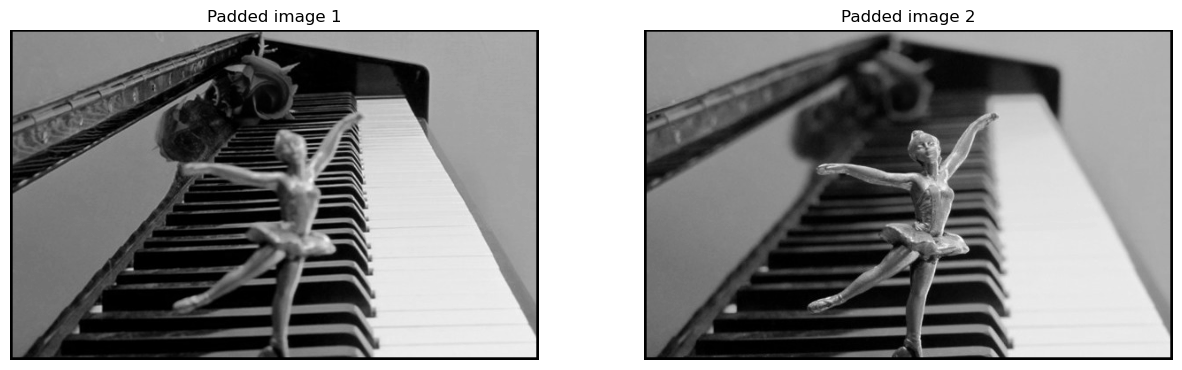

In [52]:
print(f"Kernel size is: {const.KERNEL_SIZE}")
print(f"Padding needed do keep same image dimensions: {const.PADDING}")

padded_images = pad_images(
    images=grayscale_imgages,
    padding=const.PADDING,
    border=cv.BORDER_CONSTANT,
)

plot_images(
    padded_images,
    titles=["Padded image 1", "Padded image 2"],
)

The **Modified Laplacian** which is a second-order derivative operator is used to extract edge information. This step is done to highlight areas with significant changes in intensity. In order to overcome the scenario where opposite signs while taking the gradient, the absolute values are used to avoid cancellation, which ensures that both derivatives contribute positively to the edge detection process.

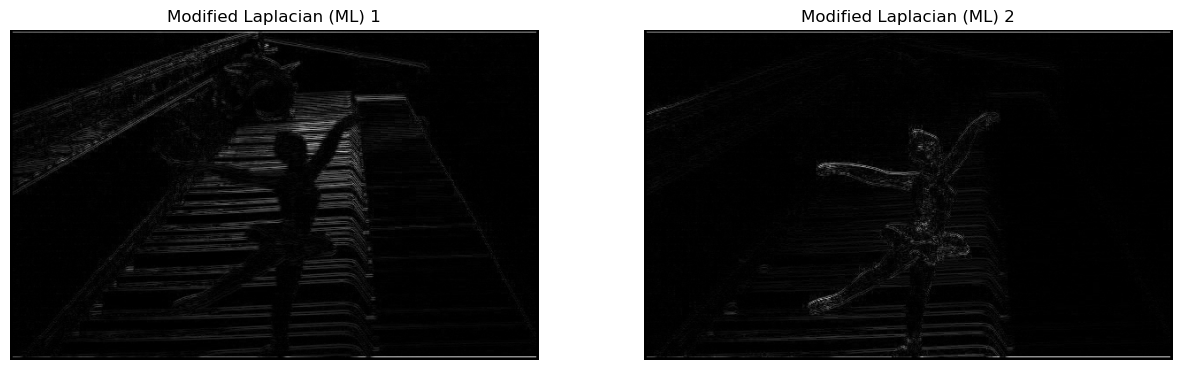

In [53]:
ml_images = ML(
    images=padded_images,
    kernel_size=const.KERNEL_SIZE,
    verbose=const.VERBOSE,
)

plot_images(
    ml_images,
    titles=["Modified Laplacian (ML) 1", "Modified Laplacian (ML) 2"],
    saveImage=True,
    savePath=save_fig_folder / "03_ML.png",
)

To further enhance the information of areas with high edge information, a Gaussian Kernel is incorporated in order to weight the ML output, increasing the robustness of the focus measure.

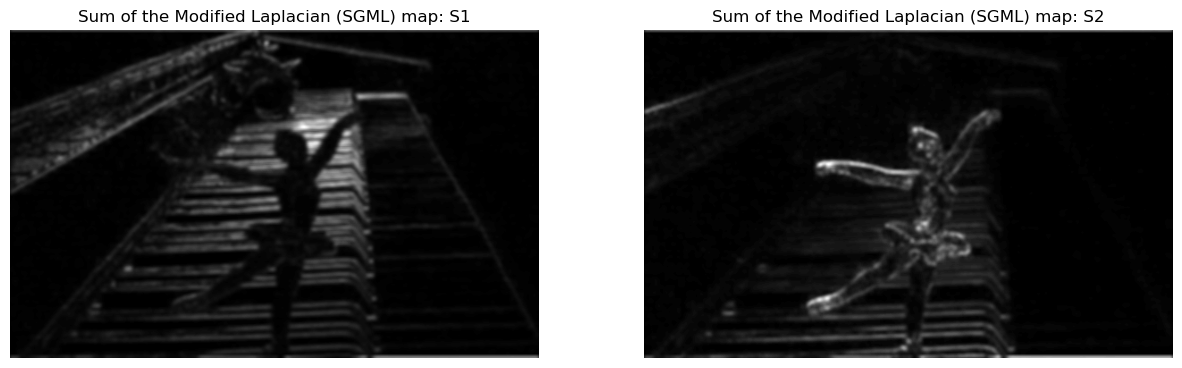

In [54]:
sgml_images = SGML(
    ml_images=ml_images,
    kernel=gaussian_kernel_2D,
    verbose=const.VERBOSE,
)

plot_images(
    sgml_images,
    titles=[
        "Sum of the Modified Laplacian (SGML) map: S1",
        "Sum of the Modified Laplacian (SGML) map: S2",
    ],
    saveImage=True,
    savePath=save_fig_folder / "04_SGML.png",
)

In [55]:
print(f"Images shape before padding: {grayscale_imgages.shape}")
print(f"Images shape after padding: {padded_images.shape}")
print(f"Images shape after ML: {ml_images.shape}")
print(f"Images shape after SGML: {sgml_images.shape}")

Images shape before padding: (2, 368, 592)
Images shape after padding: (2, 374, 598)
Images shape after ML: (2, 374, 598)
Images shape after SGML: (2, 368, 592)


<a id="strategy-of-initial-segmentation"></a>
## 3.2. Strategy of initial segmentation

The Strategy of Initial Segmentation is a crucial step in the multi-focus image fusion process. This strategy involves dividing the source images into distinct regions based on their focus information. The process is as follows:

1. **Focus Maps Generation**:
   Initially, focus maps (denoted as $S1$ and $S2$) were generated for the source images using the **SGML focus measure**. These maps highlight the focused and non-focused areas in the images. 

2. **Sliding Window Strategy**:
   A novel **sliding window strategy** is employed for this segmentation. The **focus maps ($S1$ and $S2$)** are divided into blocks of size $n \times n$ using a sliding window approach. At each step the sum of all the coefficients is computed and the corresponding indices in the **focus scores matrices ($F1$ and $F2$)** are incremented. The index that is incremented is the one with a higher sum for the current patch which means a higher energy density.
   
3. **Segmentation into Three Regions**:
   The **focus score matrices ($F1$ and $F2$)** are then used to segment the **initial segmentation maps ($I1$ and $I2$)** into three distinct regions:
   - **1** = Focused areas
   - **0** = Unfocused areas
   - **0.5** =Uncertain areas
  
   Subsequently, **morphological opening and closing operations** are employed to eliminate isolated points that are encompassed by the focused region.

4. **Initial Segmentation Map**:
   Based on the comparison of focus maps within each block, an initial decision map is created. This map categorizes each block of the source images into one of the three regions: focused, unfocused, or uncertain.

This initial segmentation is pivotal for the subsequent image matting and fusion steps, as it lays the groundwork for accurately combining the focused regions from multiple images into a single, all-in-focus image.

In [56]:
focus_maps = sgml_images.copy()
print(f"focus_maps shape: {focus_maps.shape}")

focus_maps shape: (2, 368, 592)


In [57]:
def compute_focus_scores(focus_maps: np.ndarray, n=8, step_size=1, verbose=False):
    """
    Computes focus scores for given focus maps using a sliding window approach.

    The function iterates over the focus maps of two images and computes focus scores for each patch.
    The focus score for a patch is determined by comparing the sum of pixel intensities in the patch for each image.
    The image with the higher sum of pixel intensities is considered to be more in focus.

    Args:
        focus_maps (np.ndarray): A 3D numpy array where the first dimension represents the image index and the second and third
        dimensions represent the y and x coordinates of a pixel. Each element represents the focus map of a pixel.
        n (int, optional): The size of the patch for which the focus score is computed. Defaults to 8.
        step_size (int, optional): The number of pixels the sliding window moves after each computation. Defaults to 1.
        verbose (bool, optional): If True, prints additional information about the computation. Defaults to False.

    Returns:
        np.ndarray: A 3D numpy array where the first dimension represents the image index and the second and third
                    dimensions represent the y and x coordinates of a pixel. Each element represents the focus score of a pixel.
    """
    # Meta info
    H, W = focus_maps[0].shape
    Q = 0  # number of patches

    # Algorithm parameters
    focus_score_matrix = np.zeros_like(focus_maps)  # F1, F2 maps
    S1, S2 = focus_maps

    # Sliding window over the image
    for y in range(n // 2, H - n // 2 + 1, step_size):
        for x in range(n // 2, W - n // 2 + 1, step_size):
            row_slice = slice(y - n // 2, y + n // 2)
            col_slice = slice(x - n // 2, x + n // 2)

            window1 = S1[row_slice, col_slice]
            window2 = S2[row_slice, col_slice]

            Q = Q + 1  # update count for number of patches

            k1 = np.sum(window1)
            k2 = np.sum(window2)

            if k1 > k2:
                focus_score_matrix[0][row_slice, col_slice] += 1
            if k2 > k1:
                focus_score_matrix[1][row_slice, col_slice] += 1
            if k1 == k2:
                focus_score_matrix[0][row_slice, col_slice] += 1
                focus_score_matrix[1][row_slice, col_slice] += 1

    if verbose:
        print(compute_focus_scores.__name__)
        print(f"y_start = {n // 2}")
        print(f"y_stop = {H - n // 2 + 1}")
        print(f"x_start = {n // 2}")
        print(f"x_stop = {W - n // 2 + 1}")
        print(f"\tInput image dimensions: H x W = {H} x {W}")
        print(f"\tNumber of patches: {Q}")
        print(
            f"\tTheoretical number of patches: (H-n+1)x(W-n+1) = {(H-n+1)}x{(W-n+1)} = {((H-n+1))*(W-n+1)}"
        )
        print(f"\tFocus scores shape: {focus_score_matrix.shape}")
        print(f"F1 == 0 : {np.sum(focus_score_matrix[0] == 0)}")
        print(f"F1 != 0 : {np.sum(focus_score_matrix[0] != 1)}")
        print(f"F2 == 0 : {np.sum(focus_score_matrix[1] == 0)}")
        print(f"F2 != 0 : {np.sum(focus_score_matrix[1] != 1)}")

    return focus_score_matrix

In [58]:
def compute_initial_segmentation_maps(focus_scores, verbose=False):
    """
    Computes initial segmentation maps based on the given focus scores. A value of 1 means the pixel is in focus,
    a value of 0 means the pixel is out of focus, and a value of 0.5 means the pixel focus is uncertain.

    Parameters:
    focus_scores (tuple of np.ndarray): A tuple containing the focus scores of two images. Each focus score
                                        is a 2D numpy array where each element represents the focus score of a pixel.
    verbose (bool, optional): If True, prints additional information about the computation. Defaults to False.

    Returns:
    np.ndarray: A 3D numpy array where the first dimension represents the image index and the second and third
                dimensions represent the y and x coordinates of a pixel. Each element represents the segmentation
                score of a pixel.
    """
    I1_IDX, I2_IDX = range(2)

    segmentation_maps = np.ones_like(focus_scores) * 0.5
    F1, F2 = focus_scores
    H, W = focus_maps[0].shape

    for y in range(H):
        for x in range(W):
            if F2[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 1
                segmentation_maps[I2_IDX, y, x] = 0
            elif F1[y, x] == 0:
                segmentation_maps[I1_IDX, y, x] = 0
                segmentation_maps[I2_IDX, y, x] = 1

    if verbose:
        print(compute_initial_segmentation_maps.__name__)
        print(segmentation_maps[0])
        print(f"\tW={W}, H={H}")
        print(f"F1.shape: {F1.shape}")
        print(f"F2.shape: {F2.shape}")
        print(f"segmentation_maps shape: {segmentation_maps.shape}")
        print(f"\tFocus scores shape: {focus_scores.shape}")
        print(f"I1 == 0 : {np.sum(segmentation_maps[0] == 0)}")
        print(f"I1 == 0.5 : {np.sum(segmentation_maps[0] == 0.5)}")
        print(f"I1 == 1 : {np.sum(segmentation_maps[0] == 1)}")
        print(f"I2 == 0 : {np.sum(segmentation_maps[1] == 0)}")
        print(f"I2 == 0.5 : {np.sum(segmentation_maps[1] == 0.5)}")
        print(f"I2 == 1 : {np.sum(segmentation_maps[1] == 1)}")

    return segmentation_maps

**Opening Operation:**

- The opening operation consists of an **erosion followed by a dilation**.
- This operation is effective in removing small foreground elements or noise, particularly in brighter regions. It can separate objects that are slightly connected and smoothens the edges of larger objects.

In [59]:
def morph_open(img, strucuting_elem, num_iterations=3):
    """
    Morphological opening is an operation that consists of erosion followed by dilation,
    usually performed on binary images. It can be used to remove noise.

    Args:
        img (np.ndarray): The input image, a 2D numpy array.
        structuring_elem (np.ndarray): The structuring element used for the morphological operation.
        num_iterations (int, optional): The number of times the operation is applied. Defaults to 3.

    Returns:
        np.ndarray: The output image after applying the morphological opening.
    """
    erosion = cv.erode(img, strucuting_elem, iterations=num_iterations)
    dilation = cv.dilate(erosion, strucuting_elem, iterations=num_iterations)
    return dilation 

**Closing Operation:**

- The closing operation involves a **dilation followed by an erosion**.
- This process effectively fills in small holes and gaps in the foreground of the image and can connect small, nearby objects. It tends to smooth contour sections while generally maintaining the shapes and sizes of larger objects in the image.

In [60]:
def morph_close(img, strucuting_elem, num_iterations=3):
    """
    Performs morphological closing on an image.

    Morphological closing is an operation that consists of dilation followed by erosion, usually performed on binary images. It can be used to close small holes and connect small breaks.

    Args:
        img (np.ndarray): The input image, a 2D numpy array.
        structuring_elem (np.ndarray): The structuring element used for the morphological operation. It is a 2D numpy array, typically a square or a circle.
        num_iterations (int, optional): The number of times the operation is applied. Defaults to 3.

    Returns:
        np.ndarray: The output image after applying the morphological closing.
    """
    dilation = cv.dilate(img, strucuting_elem, iterations=num_iterations)
    erosion = cv.erode(dilation, strucuting_elem, iterations=num_iterations)
    return erosion

In [61]:
def apply_morphology_filter(
    initial_semgnetaion_maps, struct_elem_size, num_iterations, verbose=False
):
    """
    This function takes as input two initial segmentation maps, applies a morphological opening filter
    to the first map and a morphological closing filter to the second map. 

    Args:
        initial_semgnetaion_maps (np.ndarray): A 3D numpy array where the first dimension represents
            the segmentation map index and the second and third dimensions represent the y and x
            coordinates of a pixel. Each element represents the pixel value in the segmentation map.
        struct_elem_size (int): The size of the structuring element for the morphological operations.
        num_iterations (int): The number of times the morphological operations are applied.
        verbose (bool, optional): If True, prints additional information about the operation. 
            Defaults to False.

    Returns:
        np.ndarray: A 3D numpy array where the first dimension represents the segmentation map index
            and the second and third dimensions represent the y and x coordinates of a pixel. Each element represents the pixel value in the filtered segmentation map.
    """
    strucuting_elem = cv.getStructuringElement(cv.MORPH_CROSS,(struct_elem_size,struct_elem_size)) 

    I1, I2 = initial_semgnetaion_maps

    M1 = morph_close(I1, strucuting_elem, num_iterations)
    M2 = morph_open(I2, strucuting_elem, num_iterations)

    if verbose:
        print(apply_morphology_filter.__name__)
        print(f"\tStrucuting element size: {struct_elem_size}")
        print(f"\tNumber of iterations: {num_iterations}")
        print(f"I1 shape: {I1.shape}")
        print(f"I2 shape: {I2.shape}")
        print(f"M1 shape: {M1.shape}")

    return np.array([M1, M2])

In [62]:
def compute_trimap(initial_segmentation_maps, verbose=False):
    """
    Computes a trimap based on two initial segmentation maps.

    A trimap is a map that classifies each pixel of an image into three categories: 
    foreground, background, and uncertain. This function computes a trimap based on two
    initial segmentation maps. The first map is assumed to represent the foreground and 
    the second map the background.

    Args:
        initial_segmentation_maps (np.ndarray): A 3D numpy array where the first dimension 
            represents the segmentation map index and the second and third dimensions represent 
            the y and x coordinates of a pixel. Each element represents the pixel value in
            the segmentation map.
        verbose (bool, optional): If True, prints additional information about the operation. 
            Defaults to False.

    Returns:
        np.ndarray: A 2D numpy array representing the computed trimap. Each element represents 
        the trimap value of a pixel.
    """
    H, W = initial_segmentation_maps[0].shape
    I1, I2 = initial_segmentation_maps

    trimap = np.ones_like(initial_segmentation_maps[0]) * 0.5

    for y in range(H):
        for x in range(W):
            if I1[y, x] == 1:
                trimap[y, x] = 1
            elif I2[y, x] == 1:
                trimap[y, x] = 0

    if verbose:
        print(compute_trimap.__name__)
        print(f"\tW={W}, H={H}")
        print(f"I1 shape: {I1.shape}")
        print(f"I2 shape: {I2.shape}")
        print(f"trimap shape: {trimap.shape}")

    return trimap

The 4 operations described at the beginning of the segmentation strategy ar applied sequentially in order to obtain the trimap as follows:

The focus maps generated thought the SGML step are fed as input to determine focus scores around each individual pixel based on the sliding window strategy proposed by the authors.

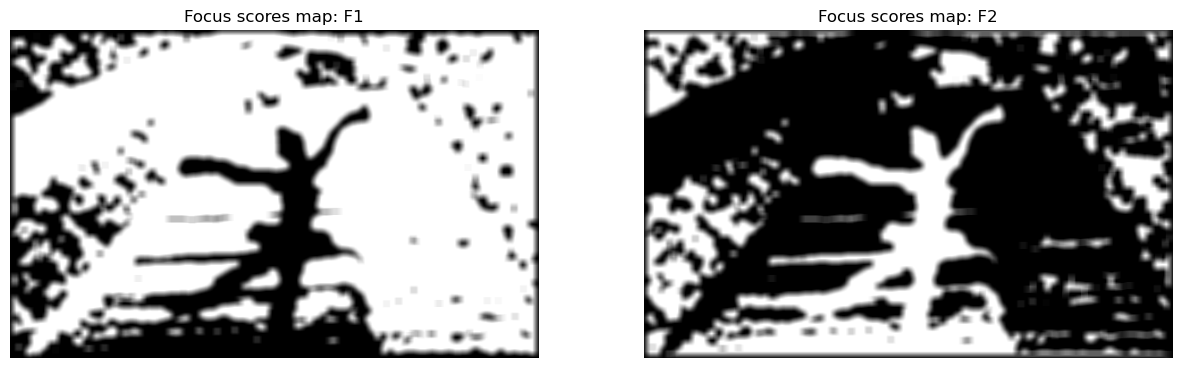

In [63]:
focus_scores = compute_focus_scores(focus_maps, n=8, step_size=1, verbose=const.VERBOSE)
plot_images(
    focus_scores,
    titles=["Focus scores map: F1", "Focus scores map: F2"],
    saveImage=True,
    savePath=save_fig_folder / "05_focus_scores.png",
)

Using the resulting focus scores from the previous step for each image, an initial segmentation map is formed in order to classify pixels into 3 categories: 
- focused
- unfocused
- unknown

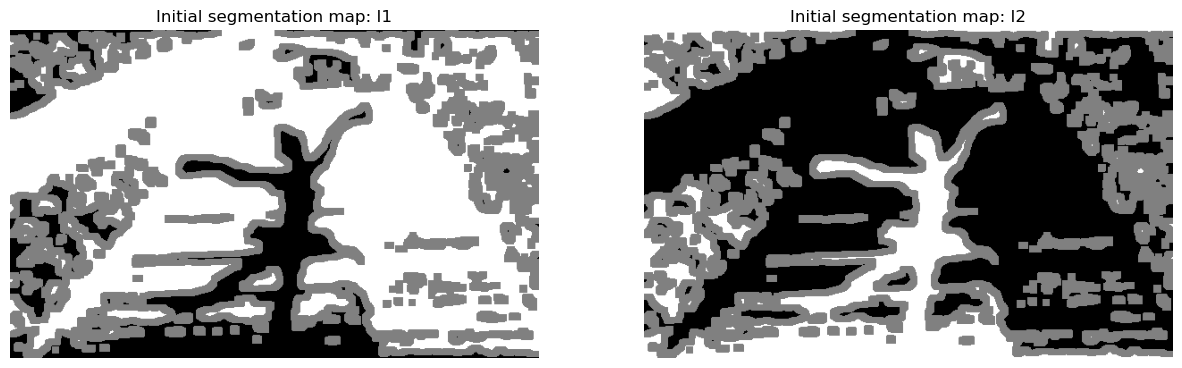

In [64]:
initial_segmentation_maps = compute_initial_segmentation_maps(
    focus_scores=focus_scores, verbose=const.VERBOSE
)
plot_images(
    initial_segmentation_maps,
    titles=["Initial segmentation map: I1", "Initial segmentation map: I2"],
    saveImage=True,
    savePath=save_fig_folder / "06_initial_segmentation_maps.png",
)

The final segmentation map is obtained after applying morphological close and open operations respectively to each map in order to eliminate scattered points around the focused area. 

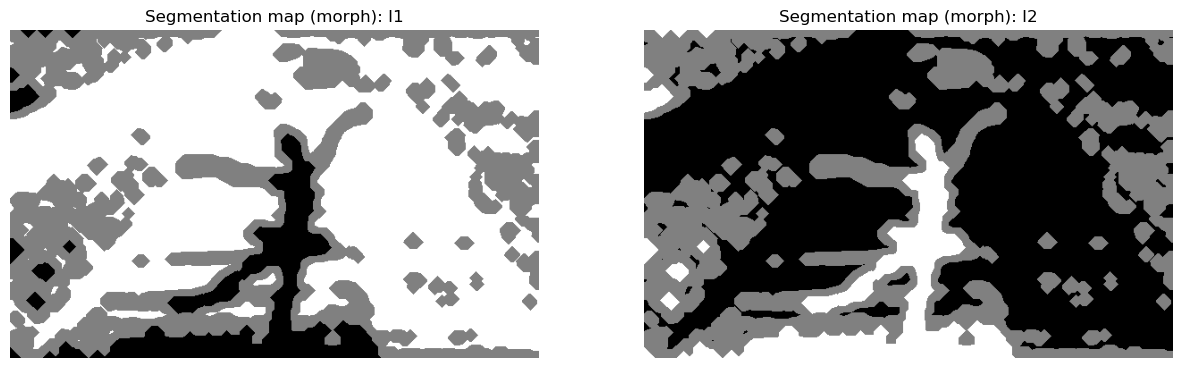

In [65]:
segmentation_maps = apply_morphology_filter(
    initial_segmentation_maps,
    struct_elem_size=const.STRUCTURING_ELEM_SIZE,
    num_iterations=const.MORPH_NUM_ITERATIONS,
    verbose=const.VERBOSE,
)
plot_images(
    segmentation_maps,
    titles=["Segmentation map (morph): I1", "Segmentation map (morph): I2"],
    saveImage=True,
    savePath=save_fig_folder / "06_segmentation_maps_morphology.png",
)

The trimap is created from the two segmentation maps, where pixels in focus from the first image are designated as the foreground with a value of 1, and pixels in focus from the second image are marked as the background with a value of 0. In the segmentation map, both foreground and background pixels are assigned a value of 1. Pixels that are not in focus in either image are considered defocused and are given a value of 0.5.

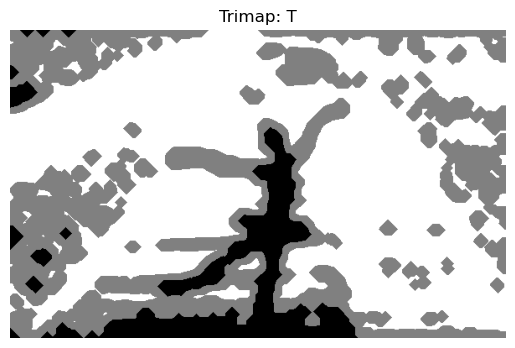

In [66]:
trimap = compute_trimap(segmentation_maps, verbose=const.VERBOSE)
plot_images(
    np.array([trimap]),
    titles=["Trimap: T"],
    isGrayscale=True,
    saveImage=True,
    savePath=save_fig_folder / "07_trimap.png",
)

<a id="#33-image-matting-technique-for-fusion"></a>
## 3.3. Image matting technique for fusion

### 3.3.1 Learning based matting method


The Learning-Based Matting method is used to extract the decision map of source images. This method focuses on accurately distinguishing between focused and defocused regions within the image by determining the alpha values (transparency levels) of pixels in an image.

The alpha matte, a key output of this process, indicates the transparency level of each pixel. Pixels with an alpha value close to 1 are considered part of the foreground (focused), while those with values close to 0 are part of the background (defocused). Pixels with intermediate alpha values indicate areas where focus is uncertain or where there is a blend of foreground and background.

It plays a vital role in ensuring that the fused image retains the best-focused areas from each of the source images, leading to a more visually appealing and information-rich final image.

In [67]:
from numpy.lib.stride_tricks import as_strided
import scipy.sparse

def rolling_block(A, block=(3, 3)):
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)

def getLapFast(img, mask, mylambda=0.0000001, win_rad=1):
    w_s = win_rad * 2 + 1
    win_size = (w_s) ** 2
    img = img / 255
    h, w, c = img.shape
    indsM = np.reshape(np.arange(h * w), (h, w))
    ravelImg = img.reshape(h * w, c)

    scribble_mask = mask != 0
    numPix4Training = np.sum(1 - scribble_mask[win_rad:-win_rad, win_rad:-win_rad])

    numNonzeroValue = numPix4Training * win_size**2

    row_inds = np.zeros(numNonzeroValue)
    col_inds = np.zeros(numNonzeroValue)
    vals = np.zeros(numNonzeroValue)

    win_indsMat = rolling_block(indsM, block=(w_s, w_s))
    win_indsMat = win_indsMat.reshape(h - 2 * win_rad, w - 2 * win_rad, win_size)

    t = 0
    # Repeat on each legal pixel
    # Cannot fully vectorize since the size of win_inds varies by the number of unknown pixels
    # If we preform the computation for all pixels in fully vectorised form it's slower.
    for i in range(h - 2 * win_rad):
        win_inds = win_indsMat[i, :]
        win_inds = win_inds[
            np.logical_not(scribble_mask[i + win_rad, win_rad : w - win_rad])
        ]
        winI = ravelImg[win_inds]
        m = winI.shape[0]
        winI = np.concatenate((winI, np.ones((m, win_size, 1))), axis=2)
        I = np.tile(np.eye(win_size), (m, 1, 1))
        I[:, -1, -1] = 0
        winITProd = np.einsum("...ij,...kj ->...ik", winI, winI)
        fenmu = winITProd + mylambda * I
        invFenmu = np.linalg.inv(fenmu)
        I1 = np.einsum("...ij,...jk->...ik", winITProd, invFenmu)
        I_F = np.eye(win_size) - I1
        lapcoeff = np.einsum("...ji,...jk->...ik", I_F, I_F)

        vals[t : t + (win_size**2) * m] = lapcoeff.ravel()
        row_inds[t : t + (win_size**2) * m] = np.repeat(win_inds, win_size).ravel()
        col_inds[t : t + (win_size**2) * m] = np.tile(win_inds, win_size).ravel()
        t = t + (win_size**2) * m
    L = scipy.sparse.coo_matrix((vals, (row_inds, col_inds)), shape=(h * w, h * w))
    return L

def solveQurdOpt(L, C, alpha_star):
    mylambda = 1e-6
    D = scipy.sparse.eye(L.shape[0])

    alpha = scipy.sparse.linalg.spsolve(L + C + D*mylambda, C @ alpha_star.ravel())
    alpha = np.reshape(alpha, alpha_star.shape)

    # if alpha value of labelled pixels are -1 and 1, the resulting alpha are
    # within [-1 1], then the alpha results need to be mapped to [0 1]
    if np.min(alpha_star.ravel()) == -1:
        alpha = alpha*0.5+0.5
    alpha = np.maximum(np.minimum(alpha, 1), 0)
    return alpha

def getC(mask, c=800):
    scribble_mask = (mask != 0).astype(int)
    numPix = np.prod(mask.shape)
    C = scipy.sparse.diags(c * scribble_mask.ravel())
    return C

In [68]:
def learning_based_matte(img, trimap, c=800, mylambda=0.0000001):
    foreground = trimap == 1
    background = trimap == 0
    mask = np.zeros(trimap.shape)
    mask[foreground] = 1
    mask[background] = -1

    L = getLapFast(img, mask, mylambda)
    C = getC(mask, c)
    alpha = solveQurdOpt(L, C, mask)
    return alpha

In [69]:
alpha0 = learning_based_matte(images[0], trimap)
alpha1 = learning_based_matte(images[1], trimap)
alpha = (alpha0 + alpha1) / 2

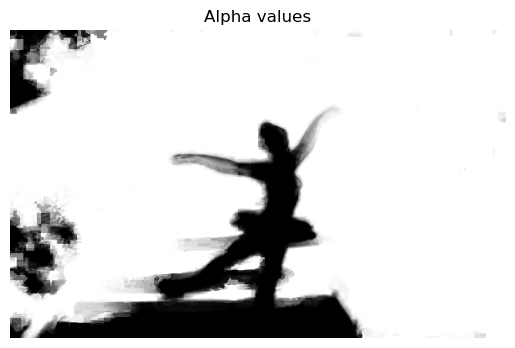

In [70]:
plot_images(
    np.array([alpha]),
    titles=["Alpha values"],
    isGrayscale=True,
    saveImage=True,
    savePath=save_fig_folder / "08_alpha_values.png",
)

### Image matting

In [71]:
def image_matting(images, alpha, verbose=False):
    """
    Performs image matting on the given images using the provided alpha.

    This function works by iterating over each pixel in the alpha. For each pixel, it computes the new value as a 
    weighted average of the corresponding pixel values in the foreground and background images, using the alpha value 
    from the alpha as the weight. The result is a new image that combines the foreground and background images 
    according to the alpha values in the alpha.

    If verbose is True, the function also prints the shapes of the alpha and the input images, as well as the number 
    of focused, unfocused, and unknown pixels in the alpha.
    
    Args:
        images (np.array): A numpy array containing two images, the foreground and the background.
        alpha (np.array): A numpy array of the same shape as the images, containing the alpha values for each pixel.
        verbose (bool, optional): If True, prints additional information about the process. Defaults to False.

    Returns:
        np.array: A numpy array of the same shape as the input images, representing the result of the image matting.
    """
    I1, I2 = images.copy()
    image_matting = np.zeros_like(images[0])

    rows, cols, _ = I1.shape
    for row in range(rows):
        for col in range(cols):
            crnt_alpha = alpha[row, col]
            image_matting[row, col] = crnt_alpha * I1[row, col] + (1 - crnt_alpha) * I2[row, col]

    if verbose:
        print(f"alpha.shape: {alpha.shape}")
        print(f"I1 (foreground) shape: {I1.shape}")
        print(f"I2 (background) shape: {I2.shape}")
        print(f"Num of focused pixels: {np.sum(alpha == 1)}")        
        print(f"Num of unfocused pixels: {np.sum(alpha == 0)}")
        print(f"Num of unknown pixels: {np.sum(alpha == 0.5)}")
        print(f"Total pixels (1 color chn): {alpha.shape[0] * alpha.shape[1]}")

    return image_matting    

The final fused image is obtained by the following pixel-wise weighted-averaging rule:
$$ I_{F} = \alpha(x,y)I_{1}(x,y) + (1 - \alpha(x,y))I_{2}(x,y) $$

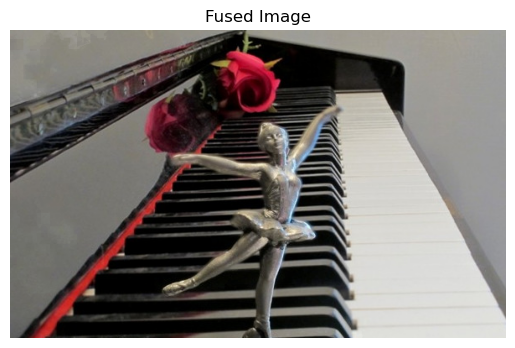

In [72]:
fused_image = image_matting(images, alpha, verbose=const.VERBOSE)
plot_images(
    np.array([fused_image]),
    titles=["Fused Image"],
    saveImage=True,
    savePath=save_fig_folder / "09_fused_image.png",
)

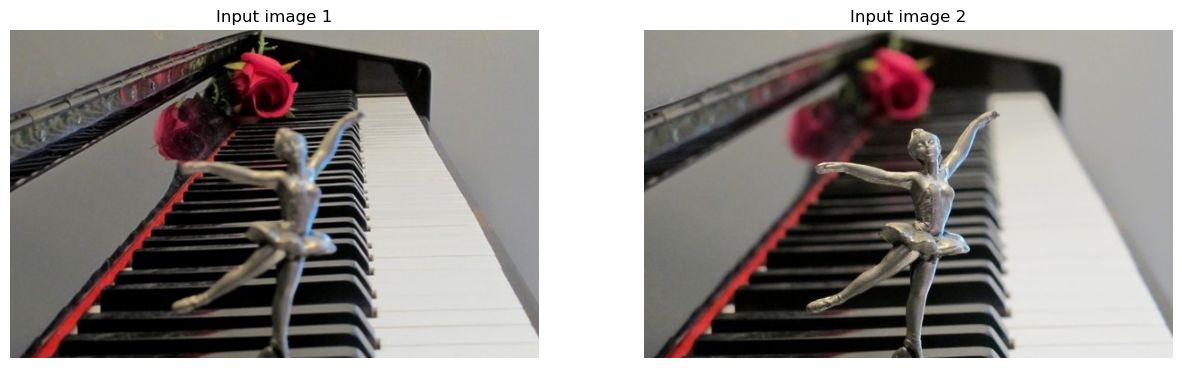

In [73]:
plot_images(images, ["Input image 1", "Input image 2"])

# References:

* Paper describing the algorithm: https://www.sciencedirect.com/science/article/pii/S1051200420301664